# Reinforcement Learning at the GYM!

The following notebook is a collection of testing and research into the topic of Reinforcement Learning. Attempting to familiarize myself with the best practices, and established a way-of-working pipeline which will be of benefit in my upcoming projects.

As a "hello world" application, the Taxi Gym environment is very popular. It poses an interesting challenge with quite an extensive observation and action environment with not too many states.

In [4]:
# The star of the show is ofcourse the Gym library by Open.AI
import gym

Various 'gaming' environments can be loaded in. These environments are represented by the `env` variable.

This is also where the `render_mode` is specified. It can be displayed in a Pygame window. But for ease of use in this notebook the 'ansi' mode will be selected.

In [5]:
env = gym.make('Taxi-v3', render_mode='ansi').env

In order to 'start' the game and visualize it, the `reset()` method is called to initiate a new 'episode'.

It can be displayed with the `render()` method. But it is quite cryptic at first.

In [6]:
env.reset()
print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




With a rendered environment, it seems everything is working. Imporant aspects of this environment are the `action_space` and `observation_space`. It is a good practice to examine the structure of these.

In [7]:
print(f'Action space: {env.action_space}')
print(f'Observation space: {env.observation_space}')

Action space: Discrete(6)
Observation space: Discrete(500)


From this it is evident that the `action_space` contains 6 inputs. This is correct as there are 
 1. South
 2. North
 3. East
 4. West
 5. Pickup
 6. Dropoff
 
possible actions

The `observation_space` contains a grid of 5x5 squares. These spaces contain 4 destinations and 4+1 passenger locations (destinations + taxi)

This brings the total to 5x5x5x4 = 500

In [8]:
env.reset(seed=69)
print(env.render())
print(env.s)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


288


Besides the action and observation space the 'reward table' is another important piece. The inital reward table is called P.

It can be considered the `state x action` matrix

In [9]:
env.P[288]

{0: [(1.0, 388, -1, False)],
 1: [(1.0, 188, -1, False)],
 2: [(1.0, 288, -1, False)],
 3: [(1.0, 268, -1, False)],
 4: [(1.0, 288, -10, False)],
 5: [(1.0, 288, -10, False)]}

The structure of the Dict is as follows:

`{action: [(probability, nextstate, reward, done)]}`

* The 0-5 corresponds to the actions (south, north, east, west, pickup, dropoff)
* In this env, probability is always 1.0.
* The nextstate is the state we would be in if we take the action at this index of the dict
* All the movement actions have a -1 reward and the pickup/dropoff actions have -10 reward in this particular state. If we are in a state where the taxi has a passenger and is on top of the right destination, we would see a reward of 20 at the dropoff action (5)
* done is used to tell us when we have successfully dropped off a passenger in the right location. Each successfull dropoff is the end of an episode

## Brute Force

Before any ML approach is attempted. It is good practice to create a baseline. In this case it will be a brute force attempt at the game. 

By using the P table for default rewards in each state, the taxi can be navigated just by using that.

An infinite loop will be create that ends when a single passenger is delivered to the right location.

In [53]:
env.reset(seed=69)

epochs = 0
penalties, rewards = 0, 0

frames = [] # animation

# episode ends due to TIME LIMIT, or not defined
truncated = False

# episode ends due to task completion or failure
terminated = False


# Loop until episode ends due to x
while not terminated or truncated:
    
    # Select a random action from the action space
    action = env.action_space.sample()
    
    state, reward, terminated, truncated, info = env.step(action)
    
    if reward == -10:
        penalties += 1
    
    # Append rendered frames into dict
    frames.append({
        'frame': env.render(),
        'state': state,
        'action': action,
        'reward': reward
    })
    
    epochs += 1

print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 1226
Penalties incurred: 410


In [54]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 99
State: 48
Action: 5
Reward: -10


KeyboardInterrupt: 

## Q-Learning 

We have observed that the brute-force method is not optimal. In some cases it reaches the goal relatively fast. But in most occasions it takes many steps. While still consisting of a limited observation space. The brute force method might seem 'ok'. But when the complexity of the environment rises. The brute force method will become useless.

That is where Q-Learning comes into play. This algorithm assigns a `Q` Value to each state and action combination. The goal of this algorithm, compared to gradient descent, is to find the maximum value of Q. This defines the optimal action for that state.

Through reinforced learning the model 'learns' these Q-values. The result is a model which chooses the optimal action in each state. Winner!

In [10]:
import numpy as np
import random
import matplotlib.pyplot as plt

An empty Q-table is created. This has the same dimensions as the observation & action space. As we are trying to find the best match with highest q-value between these two variables.

In [11]:
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In order for our model to 'learn' some pre-requisits are:
1. Create the environment
2. Define q-table
3. Iterate over number of episodes
4. Select action with MAX return from q-table or perform random action (epsilon)
5. Take a step in the environment with the selected action
6. Update the q-table at Q[state, action]
7. handle rewards for graphing

In [109]:
def plot_figures(x, y, title):
    for i in range(len(y)):
        plt.figure(i)
        plt.plot(x, y[i])
        plt.title(title[i])
        plt.xscale('log')
    plt.show()
    
def print_metrics(all_epochs, all_illegal, all_steps):
    x = list(range(1, len(all_epochs)+1))
    plot_figures(x, [all_steps, all_illegal], ['action without reward (steps)', 'illegal dropoff/pickup'])
    
def train_q(alpha, gamma, epsilon, episodes, q_table, filename):    
    env = gym.make("Taxi-v3", render_mode="ansi").env

    q_table = np.zeros([env.observation_space.n, env.action_space.n])

    # Plotting metrics
    all_epochs = []
    all_illegal = []
    all_steps = []
    all_rewards = []
    
    for i in range (1, episodes):
        state, env_info = env.reset()
        epochs, illegal, steps, total_reward = 0, 0, 0, 0
        terminated = False
        truncated = False
        
        while not terminated or truncated:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Explore action space
            else:
                action = np.argmax(q_table[state])
            
            next_state, reward, terminated, truncated, info = env.step(action)
        
#             old_value = q_table[state, action]
#             next_max = np.max(q_table[next_state])
#             new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
#             q_table[state, action] = new_value
            q_table[state, action] = q_table[state, action] + alpha * (reward + gamma * np.max(q_table[next_state, :]) - q_table[state, action])
            
            if reward == -10:
                illegal += 1
            if reward == -1:
                steps += 1
                total_reward += reward
            if reward == 20:
                total_reward += reward

            state = next_state
            epochs += 1

        all_epochs.append(epochs)
        all_illegal.append(illegal)
        all_steps.append(steps)
        all_rewards.append(total_reward)

        if i % 100 == 0:
            clear_output(wait=True)
            print(f'Episode: {i}')

    print("Training finished \n")

    np.savetxt(filename, q_table, delimiter=",")
    
    print_metrics(all_epochs, all_illegal, all_steps)
    return q_table, all_epochs, all_steps, all_illegal, all_rewards

In [88]:
q_table[288]

array([-2.42507887, -2.42252486, -2.42699869, -2.41837145, -6.37463169,
       -6.74709993])

The resulting Q-table for a specific state returns the probabillity of each action. The highest scoring value is the optimal action.

Episode: 10000
Training finished 



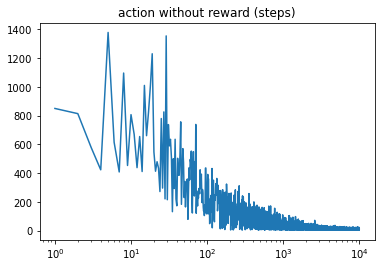

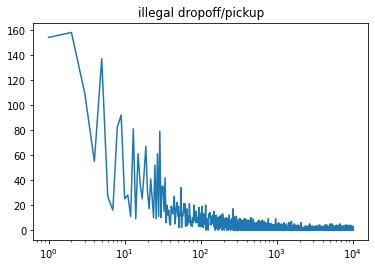

CPU times: total: 12.4 s
Wall time: 11.4 s


In [108]:
%%time
q_table, epochs, steps, illegal, rewards = train_q(0.1, 0.6, 0.1, 10001, q_table, 'q_table_from_function')

Episode: 10000
Training finished 



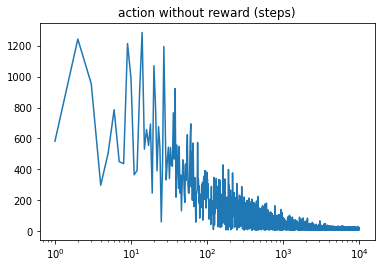

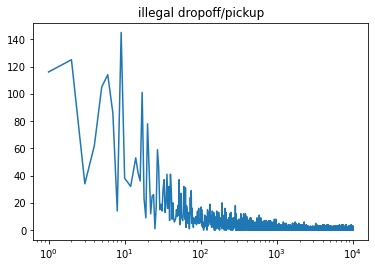

CPU times: total: 12.7 s
Wall time: 12 s


In [111]:
%%time
q_table, epochs, steps, illegal, rewards = train_q(0.1, 0.6, 0.1, 10001, q_table, 'q_table_from_function')

Episode: 10000
Training finished 



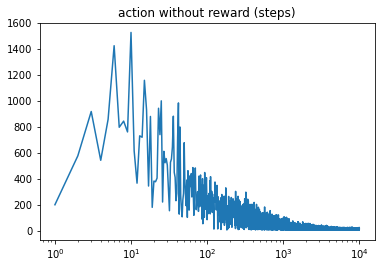

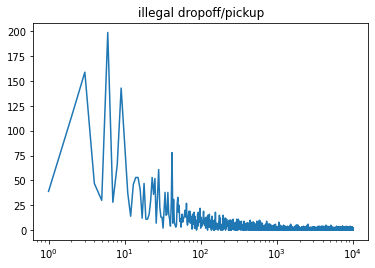

CPU times: total: 12.6 s
Wall time: 11.6 s


In [104]:
%%time
q_table, epochs, steps, illegal, rewards = train_q(0.1, 0.6, 0.1, 10001, q_table, 'q_table_from_function')

You can observe little difference in how the model acts. Small tweaks to the structure of the greedy action algorithm have a big impact on the result. Changes to how the q-value is calculated have a very large impact. 

Now if we want the game to 'play' itself. We can call almost the same function as the training method. But this time the action selection is not performed. The highest scoring action is selected for each state.

In [1]:
def play_q(episodes, q_table):
    total_epochs, total_penalties = 0, 0
    frames = []

    for _ in range(episodes):
        state, env_info = env.reset()
        epochs, penalties, reward = 0, 0, 0

        terminated = False
        truncated = False

        while not terminated or truncated:
            action = np.argmax(q_table[state])
            state, reward, terminated, truncated, info = env.step(action)

            if reward == -10:
                penalties += 1

            frames.append({
                'frame': env.render(),
                'state': state,
                'action': action,
                'reward': reward
            })

            epochs += 1

        total_penalties += penalties
        total_epochs += epochs

    print(f"Results after {episodes} episodes:")
    print(f"Average timesteps per episode: {total_epochs / episodes}")
    print(f"Average penalties per episode: {total_penalties / episodes}")

    print_frames(frames)

In [98]:
play_q(1, q_table)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 10
State: 475
Action: 5
Reward: 20


In [43]:
from gym.wrappers.monitoring import video_recorder
import numpy as np
import glob
import io, base64
from IPython import display
from IPython.core.display import HTML
import html

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        
def show_video_of_model(env_name):
    env = gym.make(env_name, render_mode='rgb_array').env
  
    env = gym.wrappers.RecordVideo(env, 'video')

    #agent.qnetwork_local.load_state_dict(torch.load('checkpointCar.pth'))
    state, state_info = env.reset()
    terminated = False
    truncated = False
    while not terminated or truncated:
        action = np.argmax(q_table[state])
        state, reward, terminated, truncated, info = env.step(action)       
    env.close()
    

In [9]:
q_table = np.loadtxt('q_table', delimiter=',')
show_video_of_model('Taxi-v3')

D:\Anaconda\lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at C:\Users\Matt\Desktop\BIGGYM\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video C:\Users\Matt\Desktop\BIGGYM\video\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\Matt\Desktop\BIGGYM\video\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Matt\Desktop\BIGGYM\video\rl-video-episode-0.mp4


In [44]:
show_video('rl-video-episode-0')

## Conclusion

There are many possibilities with reinforcement learning. The choice of algorithm is very important. The hardest part is selecting the right hyperparameters, and also constructing a well-functioning reward system. With a game like taxi that has a very small observation space it is not so difficult.

The next exercise will tackle a harder problem